# Macroeconomic Forecasting Model with Sentiment Scores

### Loading Package

In [1]:
import numpy as np
import pandas as pd

### Reading in Macroeconomics Data

In [2]:
raw_US_gdp = pd.read_csv(r"Data\FRED\GDPC1.csv").set_index('DATE')
raw_US_inflation = pd.read_csv(r"Data\FRED\FPCPITOTLZGUSA.csv").set_index('DATE')
raw_US_unemployment = pd.read_csv(r"Data\FRED\UNRATE.csv").set_index('DATE')

In [3]:
raw_US_gdp.index = pd.to_datetime(raw_US_gdp.index)
raw_US_inflation.index = pd.to_datetime(raw_US_inflation.index)
raw_US_unemployment.index = pd.to_datetime(raw_US_unemployment.index)

In [4]:
data_US_unemployment = (raw_US_unemployment - raw_US_unemployment.shift(1))[1:]
data_US_unemployment['year'] = data_US_unemployment.index.year
data_US_unemployment['month'] = data_US_unemployment.index.month
data_US_unemployment = data_US_unemployment.reset_index().set_index(['year','month']).drop(columns = ['DATE'])

In [5]:
data_US_growth = ((raw_US_gdp - raw_US_gdp.shift(1)) / raw_US_gdp)[1:]
data_US_growth['year'] = data_US_growth.index.year
data_US_growth['quarter'] = np.ceil(data_US_growth.index.month / 3).astype(int)
data_US_growth = data_US_growth.reset_index().set_index(['year','quarter']).drop(columns = ['DATE'])

In [6]:
data_US_inflation = (raw_US_inflation - raw_US_inflation.shift(1))[1:]
data_US_inflation['year'] = data_US_inflation.index.year
data_US_inflation = data_US_inflation.reset_index().set_index(['year']).drop(columns = ['DATE'])

### Reading in Sentiment Score Data

In [7]:
sentiment_score_lr = pd.read_csv(r"Data\sentiment_score_lr.csv").set_index(['year','month']).drop(columns=['exception'])
sentiment_score_lr["sum"] = sentiment_score_lr.sum(axis=1)
sentiment_score_lr = sentiment_score_lr.div(sentiment_score_lr["sum"], axis=0).drop(columns=['sum'])

sentiment_score_lstm = pd.read_csv(r"Data\sentiment_score_lstm.csv").set_index(['year','month']).drop(columns=['exception'])
sentiment_score_lstm["sum"] = sentiment_score_lstm.sum(axis=1)
sentiment_score_lstm = sentiment_score_lstm.div(sentiment_score_lstm["sum"], axis=0).drop(columns=['sum'])

In [8]:
sentiment_score_lr = sentiment_score_lr.rename(columns={"positive": "positive_lr", "neutral": "neutral_lr", "negative": "negative_lr"})
sentiment_score_lstm = sentiment_score_lstm.rename(columns={"positive": "positive_lstm", "neutral": "neutral_lstm", "negative": "negative_lstm"})
sentiment_score = sentiment_score_lr.join(sentiment_score_lstm)

In [9]:
year1 = []
year4 = []
period4 = []
i = 2013
year1.append(i)
for j in range(1, 4):
    year4.append(i)
    period4.append(j+1)
for i in range(2014, 2021):
    year1.append(i)
    for j in range(0, 4):
        year4.append(i)
        period4.append(j+1)
i = 2021
year1.append(i)
for j in range(0, 3):
    year4.append(i)
    period4.append(j+1)

In [10]:
column_name = ['positive_lr', 'neutral_lr', 'negative_lr', 'positive_lstm', 'neutral_lstm', 'negative_lstm']

sentiment_score_yearly = pd.DataFrame(np.zeros((len(year1), len(column_name))), index = year1, columns = column_name)
sentiment_score_yearly = sentiment_score_yearly.reset_index().rename(columns={"index": "year"}).set_index('year')
for year in sentiment_score_yearly.index:
    sentiment_score_yearly.loc[year] = sentiment_score.loc[year].mean(axis=0)

sentiment_score_quarterly = pd.DataFrame(np.zeros((len(year4), len(column_name))), index = [year4, period4], columns = column_name)
sentiment_score_quarterly = sentiment_score_quarterly.reset_index().rename(columns={"level_0": "year", "level_1": "quarter"}).set_index(['year','quarter'])
for (year,quarter) in sentiment_score_quarterly.index:
    year_match = sentiment_score.index.get_level_values('year') == year
    quarter_match = np.ceil(sentiment_score.index.get_level_values('month') / 3) == quarter
    sentiment_score_quarterly.loc[year, quarter] = sentiment_score[year_match * quarter_match].mean(axis=0)

sentiment_score_monthly = sentiment_score

### Combine the Datasets

In [11]:
data_US_unemployment['lag_UNRATE'] = np.nan
data_US_unemployment['lag_UNRATE'].iloc[1:] = data_US_unemployment['UNRATE'].iloc[0:-1].to_list()
data_withSentiment_US_unemployment = sentiment_score_monthly.join(data_US_unemployment)

In [12]:
data_US_growth['lag_GDPC1'] = np.nan
data_US_growth['lag_GDPC1'].iloc[1:] = data_US_growth['GDPC1'].iloc[0:-1].to_list()
data_withSentiment_US_growth = sentiment_score_quarterly.join(data_US_growth)

In [13]:
data_US_inflation['lag_FPCPITOTLZGUSA'] = np.nan
data_US_inflation['lag_FPCPITOTLZGUSA'].iloc[1:] = data_US_inflation['FPCPITOTLZGUSA'].iloc[0:-1].to_list()
data_withSentiment_US_inflation = sentiment_score_yearly.join(data_US_inflation).drop(2021)

### Exploratory Data Analysis

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

P-value:  7.397612401647015e-17


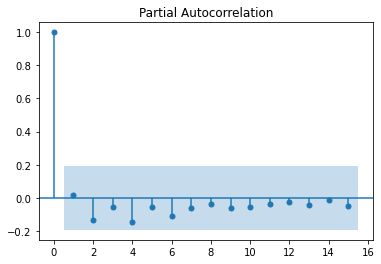

In [15]:
df = data_withSentiment_US_unemployment['UNRATE']
stationarityTest_US_unemployment = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_unemployment[1])
pacf = plot_pacf(df, lags=15)

P-value:  9.641597280523476e-11


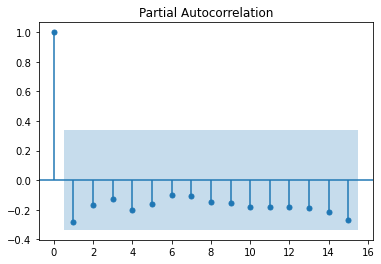

In [16]:
df = data_withSentiment_US_growth['GDPC1']
stationarityTest_US_growth = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_growth[1])
pacf = plot_pacf(df, lags=15)

P-value:  4.2996925813432326e-05


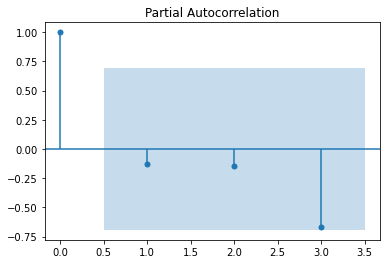

In [17]:
df = data_withSentiment_US_inflation['FPCPITOTLZGUSA']
stationarityTest_US_inflation = adfuller(df, autolag='AIC')
print("P-value: ", stationarityTest_US_inflation[1])
pacf = plot_pacf(df, lags=3)

### Baseline Model

In [18]:
import statsmodels.api as sm

In [19]:
X = sm.add_constant(data_withSentiment_US_unemployment['lag_UNRATE'])
Y = data_withSentiment_US_unemployment['UNRATE']
ar_model_US_unemployment = sm.OLS(Y,X).fit()
print(ar_model_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03267
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.857
Time:                        01:42:43   Log-Likelihood:                -154.54
No. Observations:                 102   AIC:                             313.1
Df Residuals:                     100   BIC:                             318.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0260      0.110     -0.236      0.8

In [20]:
X = sm.add_constant(data_withSentiment_US_growth['lag_GDPC1'])
Y = data_withSentiment_US_growth['GDPC1']
ar_model_US_growth = sm.OLS(Y,X).fit()
print(ar_model_US_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2.560
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.119
Time:                        01:42:43   Log-Likelihood:                 83.556
No. Observations:                  34   AIC:                            -163.1
Df Residuals:                      32   BIC:                            -160.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.004      1.609      0.1

In [21]:
X = sm.add_constant(data_withSentiment_US_inflation['lag_FPCPITOTLZGUSA'])
Y = data_withSentiment_US_inflation['FPCPITOTLZGUSA']
ar_model_US_inflation = sm.OLS(Y,X).fit()
print(ar_model_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.166
Method:                 Least Squares   F-statistic:                  0.001841
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.967
Time:                        01:42:44   Log-Likelihood:                -9.8181
No. Observations:                   8   AIC:                             23.64
Df Residuals:                       6   BIC:                             23.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1072      0

C:\ProgramData\Anaconda3\envs\nlu\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Model with Sentiment Scores (LR Model)

In [22]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'positive_lr','neutral_lr','negative_lr']])
Y = data_withSentiment_US_unemployment['UNRATE']
lr_model_withSentiment_current_US_unemployment = sm.OLS(Y,X).fit()
print(lr_model_withSentiment_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                   0.02730
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.994
Time:                        01:42:45   Log-Likelihood:                -154.51
No. Observations:                 102   AIC:                             317.0
Df Residuals:                      98   BIC:                             327.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0205      0.085     -0.242      

In [23]:
X = sm.add_constant(data_withSentiment_US_inflation[['lag_FPCPITOTLZGUSA', 'positive_lr','neutral_lr','negative_lr']])
Y = data_withSentiment_US_inflation['FPCPITOTLZGUSA']
lr_model_withSentiment_current_US_inflation = sm.OLS(Y,X).fit()
print(lr_model_withSentiment_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     2.406
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.208
Time:                        01:42:46   Log-Likelihood:                -5.6939
No. Observations:                   8   AIC:                             19.39
Df Residuals:                       4   BIC:                             19.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1349      0

C:\ProgramData\Anaconda3\envs\nlu\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Model with Sentiment Scores (LSTM Model)

In [24]:
X = sm.add_constant(data_withSentiment_US_unemployment[['lag_UNRATE', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_unemployment['UNRATE']
lstm_model_withSentiment_current_US_unemployment = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment_current_US_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                   0.02730
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.994
Time:                        01:42:47   Log-Likelihood:                -154.51
No. Observations:                 102   AIC:                             317.0
Df Residuals:                      98   BIC:                             327.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0205      0.085     -0.242

In [25]:
X = sm.add_constant(data_withSentiment_US_growth[['lag_GDPC1', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_growth['GDPC1']
lstm_model_withSentiment_current_US_growth = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment_current_US_growth.summary())

                            OLS Regression Results                            
Dep. Variable:                  GDPC1   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.8014
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.503
Time:                        01:42:47   Log-Likelihood:                 83.558
No. Observations:                  34   AIC:                            -159.1
Df Residuals:                      30   BIC:                            -153.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0046      0.003      1.411

In [26]:
X = sm.add_constant(data_withSentiment_US_inflation[['lag_FPCPITOTLZGUSA', 'positive_lstm','neutral_lstm','negative_lstm']])
Y = data_withSentiment_US_inflation['FPCPITOTLZGUSA']
lstm_model_withSentiment_current_US_inflation = sm.OLS(Y,X).fit()
print(lstm_model_withSentiment_current_US_inflation.summary())

                            OLS Regression Results                            
Dep. Variable:         FPCPITOTLZGUSA   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     2.406
Date:                Tue, 02 Nov 2021   Prob (F-statistic):              0.208
Time:                        01:42:48   Log-Likelihood:                -5.6939
No. Observations:                   8   AIC:                             19.39
Df Residuals:                       4   BIC:                             19.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1349      0

C:\ProgramData\Anaconda3\envs\nlu\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
